In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import AutoLocator, AutoMinorLocator, FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter
from matplotlib import patches
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch, AsymmetricPercentileInterval, SqrtStretch
from astropy.io import fits
import h5py
from matplotlib.path import Path


In [12]:
with h5py.File("../../sav/Eclipse/FitResults/FeXIV_63.h5", 'r') as hf:
    green_fit_matrix_ext = hf['green_fit_matrix_ext'][:]
    green_fit_matrix_ext_err = hf['green_fit_matrix_ext_err'][:]
    green_fit_matrix_bin_ext = hf['green_fit_matrix_bin_ext'][:]
    green_fit_matrix_bin_ext_err = hf['green_fit_matrix_bin_ext_err'][:]
    green_fit_filename_index = hf['green_fit_filename_index'][:]

In [3]:
with h5py.File("../../sav/Eclipse/DataGrid/FeXIV_bin_grid.h5", 'r') as hf:
    pamis_gridedge_mesh_x = hf['pamis_gridedge_mesh_x'][:]
    pamis_gridedge_mesh_y = hf['pamis_gridedge_mesh_y'][:]
    


In [44]:
with fits.open("../../src/CoMP/new_l2/20170821.comp.1074.l2/20170821.comp.1074.quick_invert.mean.synoptic.fts.gz") as hdul:
    hdul.info()
    header = hdul[0].header
    intensity = np.copy(hdul[4].data)
    enhanced_intensity = np.copy(hdul[5].data)
    vlos = np.copy(hdul[6].data)
    dlamb = np.copy(hdul[7].data)

# with fits.open("../../src/CoMP/new_l2/20170821.comp.1074.l2/20170821.174607.comp.1074.dynamics.fts.gz") as hdul:
#     hdul.info()
#     header = hdul[0].header
#     intensity = np.copy(hdul[1].data)
#     enhanced_intensity = np.copy(hdul[2].data)
#     vlos = np.copy(hdul[3].data)
#     dlamb = np.copy(hdul[4].data)

comp_nx, comp_ny = 620, 620
comp_xcoord = np.linspace(1 - header["CRPIX1"], comp_nx - header["CRPIX1"], comp_nx)*header["CDELT1"]
comp_ycoord = np.linspace(1 - header["CRPIX2"], comp_nx - header["CRPIX2"], comp_ny)*header["CDELT2"]

comp_mesh_x, comp_mesh_y = np.meshgrid(comp_xcoord, comp_ycoord)
vlos_norm = vlos - np.nanmedian(vlos[:,:310])

Filename: ../../src/CoMP/new_l2/20170821.comp.1074.l2/20170821.comp.1074.quick_invert.mean.synoptic.fts.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      91   ()      
  1  I             1 ImageHDU        52   (620, 620)   float32   
  2  Q             1 ImageHDU        52   (620, 620)   float32   
  3  U             1 ImageHDU        52   (620, 620)   float32   
  4  Linear Polarization    1 ImageHDU        52   (620, 620)   float32   
  5  Azimuth       1 ImageHDU        53   (620, 620)   float32   
  6  Doppler Velocity    1 ImageHDU        53   (620, 620)   float64   
  7  Line Width    1 ImageHDU        52   (620, 620)   float64   
  8  Radial Azimuth    1 ImageHDU        52   (620, 620)   float32   


In [45]:
pamis_gridedge_mesh_x.shape

(71, 189)

In [46]:
green_fit_matrix_bin_ext.shape

(5, 70, 188)

In [47]:
comp_aver_vlos_plot = np.full(green_fit_matrix_bin_ext.shape[1:],np.nan)
comp_aver_dlamb_plot = np.full(green_fit_matrix_bin_ext.shape[1:],np.nan)

In [48]:
green_fit_filename_index > 0

array([ True,  True,  True,  True,  True,  True, False, False,  True,
        True, False,  True, False, False,  True,  True,  True,  True,
        True,  True, False, False,  True,  True, False,  True, False,
       False,  True,  True,  True,  True,  True,  True, False, False,
        True,  True, False,  True, False, False,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True, False, False,
        True,  True,  True,  True,  True,  True, False, False,  True,
        True, False,  True, False, False,  True,  True,  True,  True,
        True,  True, False, False,  True,  True, False,  True, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True, False, False,  True,  True, False,  True, False, False,
        True,  True,  True,  True,  True,  True, False, False,  True,
        True, False,  True, False, False,  True,  True,  True,  True,
        True,  True,

In [49]:
ii = 0
comp_delete_list = []

while ii < (pamis_gridedge_mesh_x.shape[1] - 1):
    if green_fit_filename_index[ii] < 0:
        comp_delete_list.append(ii)
        ii = ii + 1
        continue
    else:
        kk = 0
        while (ii+kk < pamis_gridedge_mesh_x.shape[1] - 2) and (np.abs(green_fit_filename_index[ii+kk] - green_fit_filename_index[ii+kk+1]) < 1e-3):
            kk = kk + 1
            comp_delete_list.append(ii+kk)
        for jj in range(pamis_gridedge_mesh_x.shape[0] - 1):
            leftbottom = (pamis_gridedge_mesh_x[jj,ii], pamis_gridedge_mesh_y[jj,ii])
            rightbottom = (pamis_gridedge_mesh_x[jj,ii+kk+1], pamis_gridedge_mesh_y[jj,ii+kk+1])
            righttop = (pamis_gridedge_mesh_x[jj+1,ii+kk+1], pamis_gridedge_mesh_y[jj+1,ii+kk+1])
            lefttop = (pamis_gridedge_mesh_x[jj+1,ii], pamis_gridedge_mesh_y[jj+1,ii])
            pamis_poly = Path([leftbottom, rightbottom, righttop, lefttop])
            
            mask_in_pamis_pixel = pamis_poly.contains_points(np.vstack((comp_mesh_x.flatten(), comp_mesh_y.flatten())).T).reshape(comp_mesh_x.shape)
            comp_aver_dlamb_plot[jj,ii:ii+kk+1] = np.nanmean(dlamb[mask_in_pamis_pixel])
            comp_aver_vlos_plot[jj,ii:ii+kk+1] = np.nanmean(vlos_norm[mask_in_pamis_pixel])
        ii = ii + kk + 1



/var/folders/9p/kj06pc4s4m30vcklbzw2hhgw0000gn/T/ipykernel_70584/602350796.py:11: RuntimeWarning: overflow encountered in scalar subtract
  while (ii+kk < pamis_gridedge_mesh_x.shape[1] - 2) and (np.abs(green_fit_filename_index[ii+kk] - green_fit_filename_index[ii+kk+1]) < 1e-3):
/var/folders/9p/kj06pc4s4m30vcklbzw2hhgw0000gn/T/ipykernel_70584/602350796.py:22: RuntimeWarning: Mean of empty slice
  comp_aver_dlamb_plot[jj,ii:ii+kk+1] = np.nanmean(dlamb[mask_in_pamis_pixel])
/var/folders/9p/kj06pc4s4m30vcklbzw2hhgw0000gn/T/ipykernel_70584/602350796.py:23: RuntimeWarning: Mean of empty slice
  comp_aver_vlos_plot[jj,ii:ii+kk+1] = np.nanmean(vlos_norm[mask_in_pamis_pixel])


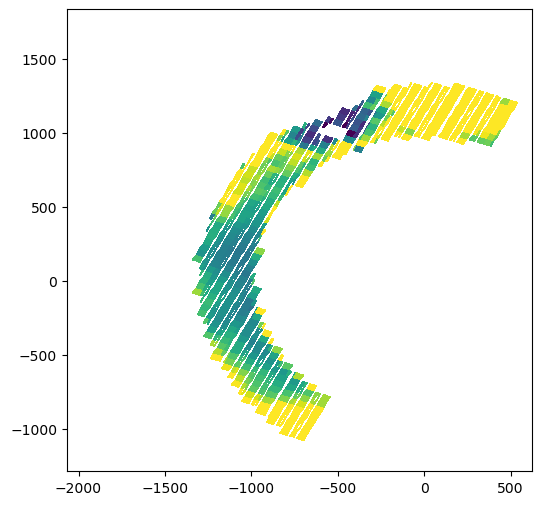

In [50]:
fig, ax = plt.subplots(figsize=(6,6))
ax.pcolormesh(pamis_gridedge_mesh_x, pamis_gridedge_mesh_y, comp_aver_dlamb_plot, vmin=25,vmax=50)

In [51]:
with h5py.File("../../sav/CoMP/FeXIII_aver.h5", 'w') as hf:
    df_comp_dlamb_plot = hf.create_dataset("comp_aver_dlamb_plot", data=comp_aver_dlamb_plot)
    df_comp_vlos_plot = hf.create_dataset("comp_aver_vlos_plot", data=comp_aver_vlos_plot)
    df_comp_delete_list = hf.create_dataset("comp_delete_list", data=comp_delete_list)